# Generative Adversarial Networks (GANs)

Need to mount my Google Drive to save e load the trained models.

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")
project_path = "/content/gdrive/MyDrive/ColabData/marktechpost/GANs"

import sys
sys.path.append('/content/gdrive/MyDrive/ColabData')

Mounted at /content/gdrive


<br><hr>

## Simple GAN

This part of the lab is based on the following Keras tutorial: [How to Develop a Conditional Generative Adversarial Network from Scratch](https://machinelearningmastery.com/how-to-develop-a-conditional-generative-adversarial-network-from-scratch/)



We will use the Fashion-MNIST dataset that contains 60000 28x28 greyscale images of 10 different types of clothes: shoes, t-shirts, ...


In [ ]:
from keras.datasets.fashion_mnist import load_data
(trainX, trainy), (testX, testy) = load_data()
print('Train', trainX.shape)
print('Test', testX.shape)

Train (60000, 28, 28)
Test (10000, 28, 28)


<br>

Let's plot an image of the dataset. Note that, the images have a black background, while the clothes are white.

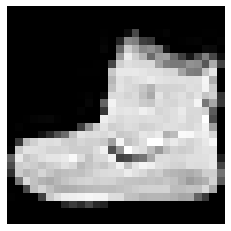

In [ ]:
import matplotlib.pyplot as plt

plt.axis('off')
plt.imshow(trainX[0], cmap='gray')

<br>

If you prefer, you can reverse the colors with the "gray_r" colormap. In this case, you'll have a white blackground with a black cloth.

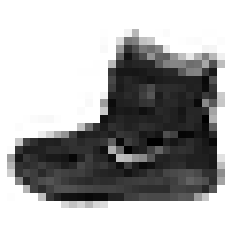

In [ ]:
plt.axis('off')
plt.imshow(trainX[0], cmap='gray_r')

<br>

Let's plot a 10x10 grid of images taken from the dataset!

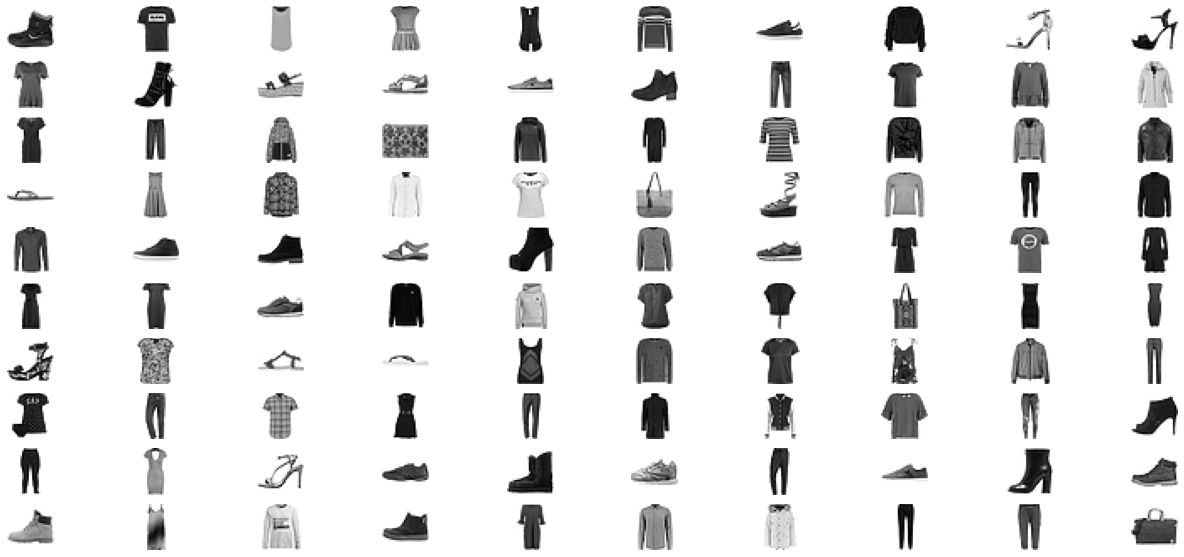

In [ ]:
plt.figure(figsize=(22,10))
for i in range(100):
	plt.subplot(10, 10, 1 + i)
	plt.axis('off')
	plt.imshow(trainX[i], cmap='gray_r')
plt.show()

<br>

Let's start building our GAN!

Since training a GAN is a hard task, we will use Convolutional Neural Networks (CNNs) which have great performance when applied to images. We will talk about CNNs in detail in another course. Here, you just have to know that CNNs are composed of Convolutional layers. These layers apply different filters to the input images to detect different features. If we stack more convolutional layers, these features are hierarchically learnt: the first layers will learn basic features like edges and borders, while the next layers will learn more complex features (like parts of an object) based on the simple features received by the previous layers.

First of all, we build the Discriminator: it receives as input a cloth image and detect if the input is real (class=1) or fake (class=0).

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, LeakyReLU, Flatten, Dropout, Reshape, Conv2DTranspose
from keras.optimizers import Adam

def get_discriminator():
  model = Sequential()
  model.add(Conv2D(128, (3,3), strides=(2,2), padding='same', input_shape=(28, 28, 1))) # the third channel is one-dimensional because we have grayscale imgs
  model.add(LeakyReLU(alpha=0.2))
  model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Flatten())
  model.add(Dropout(0.4))
  model.add(Dense(1, activation='sigmoid'))
  adam = Adam(lr=0.0002, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
  return model

<br>

The generator takes as input a N-dimensional vector from the latent space and outputs a 28x28 image. [Here](https://datascience.stackexchange.com/questions/6107/what-are-deconvolutional-layers) you can find an explaination about the Conv2DTranspose layer.

In [ ]:
def get_generator(latent_dim):
  model = Sequential()
  n_neurons = 7 * 7 * 128
  model.add(Dense(n_neurons, input_dim=latent_dim))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Reshape((7, 7, 128)))

  model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')) # upsample to 128 feature maps of shape 14x14
  model.add(LeakyReLU(alpha=0.2))
  
  model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')) # upsample to 128 feature maps of shape 28x28
  model.add(LeakyReLU(alpha=0.2))

  model.add(Conv2D(1, (7,7), activation='tanh', padding='same'))        # generate 1 feature map of shape 28x28
  return model

<br>

Now, we can define the GAN as a combination of the Generator and the Discriminator. The GAN will be used to train the weights of the Generator, leveraging the output and the error computed by the Discriminator.

We will separately train the Discriminator, so, within the GAN, we mark its weights as not trainable. In this way, when we will train the GAN, only the weights of the Generator will be updated.

The GAN takes as input a point of the latent space and use it to create a 28x28 image with the Generator. This image is then given as input to the Discriminator that will detect whether it is real or fake.

In [ ]:
def get_gan(generator, discriminator):
  discriminator.trainable = False                               # make Discriminator weights not trainable
  model = Sequential()
  model.add(generator)
  model.add(discriminator)
  adam = Adam(lr=0.0002, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer=adam)
  return model

<br>

Here, we define a function that takes random (real) samples from the training set.

In [ ]:
from numpy.random import randint
import numpy as np

def get_real_samples(training_set, n_samples):
  X = np.expand_dims(training_set, axis=-1)     # add one-dimensional color dimension
  X = X.astype('float32')                       # from integers to floats
  X = (X - 127.5) / 127.5                       # scaling from [0,255] to [-1,1]

  idxs = randint(0, len(X), n_samples)          # choose random instances
  X = X[idxs]
  y = np.ones((n_samples, 1))                   # generate class labels. Class = 1 (ones function) indicates real samples
  return X, y

<br>

Then, we define the function that generate random points from the latent space that follows a Gaussian distribution.

In [ ]:
from numpy.random import randn

def generate_latent_points(latent_dim, n_samples):
	x_input = randn(latent_dim * n_samples)             # generate random points in the latent space
	x_input = x_input.reshape(n_samples, latent_dim)  	# reshape into batches that will be the input of the network
	return x_input

<br>

Finally, we define a function that give as input to the Generator some latent points. The output of the Generator will be the fake images.

In [ ]:
def generate_fake_samples(generator, latent_dim, n_samples):
	x_input = generate_latent_points(latent_dim, n_samples)
	X = generator.predict(x_input)                                # generate new content
	y = np.zeros((n_samples, 1))                                  # generate class labels. Class = 0 (zeros function) indicates fake samples 
	return X, y

<br>

Now, we are ready to train the GAN!

For the training process, we use 25 epochs with a batch size of 256 real and fake samples.

First, the Discriminator is train with half batch of real samples, then with half batch of fake samples. Hence, the Generator is updated by training the GAN.

Note that, the fake samples generated by the Generator are labeled with the class 1 (the real samples class), so that the Generator will learn how to fool the Discriminator with samples which look real.

In [ ]:
def train(generator, discriminator, gan, training_set, latent_dim, n_epochs=25, n_batch=256):
  batch_per_epoch = int(len(training_set) / n_batch)
  half_batch = int(n_batch / 2)
  
  for i in range(n_epochs):   # one iteration per epoch
    for j in range(batch_per_epoch):  # one iteration per batch
      X_real, y_real = get_real_samples(training_set, half_batch)                               # randomly pick real examples

      discriminator_loss1, _ = discriminator.train_on_batch(X_real, y_real)                     # update the Discriminator weights based on real examples

      X_fake, y_fake = generate_fake_samples(generator, latent_dim, half_batch)                 # generate fake examples

      discriminator_loss2, _ = discriminator.train_on_batch(X_fake, y_fake)                     # update the Discriminator weights based on fake examples

      X_gan = generate_latent_points(latent_dim, n_batch)                                       # randomly generate points from the latent space

      y_gan = np.ones((n_batch, 1))                                                             # create labels for the fake examples to fool the Discriminator (so Class = 1 as real examples)

      gan_loss = gan_model.train_on_batch(X_gan, y_gan)                                         # update the Generator weights through the Discriminator's error
      
      # print loss info for each batch of each epoch
      print("\r", end="")
      print("Epoch {}/{} - Batch {}/{} - discr_loss1 = {:.3f} - discr_loss2 = {:.3f} - gan_loss = {:.3f}"
              .format(i+1, n_epochs, j+1, batch_per_epoch, discriminator_loss1, discriminator_loss2, gan_loss), 
              end="", flush=True)
    print()

  generator.save('{}/simple-generator.h5'.format(project_path))   # we can save the Generator in this way
  return generator

In [ ]:
latent_dim = 100
discriminator = get_discriminator()
generator = get_generator(latent_dim)
gan_model = get_gan(generator, discriminator)
training_set = trainX.reshape(len(trainX), 28, 28, 1)   # the CNN wants the color channel. In this case it is one-dimensional since we have grayscale images
generator = train(generator, discriminator, gan_model, training_set, latent_dim)

Epoch 1/25 - Batch 234/234 - discr_loss1 = 0.682 - discr_loss2 = 0.710 - gan_loss = 0.758
Epoch 2/25 - Batch 234/234 - discr_loss1 = 0.688 - discr_loss2 = 0.701 - gan_loss = 0.712
Epoch 3/25 - Batch 234/234 - discr_loss1 = 0.700 - discr_loss2 = 0.708 - gan_loss = 0.715
Epoch 4/25 - Batch 234/234 - discr_loss1 = 0.688 - discr_loss2 = 0.682 - gan_loss = 0.730
Epoch 5/25 - Batch 234/234 - discr_loss1 = 0.656 - discr_loss2 = 0.689 - gan_loss = 0.721
Epoch 6/25 - Batch 234/234 - discr_loss1 = 0.709 - discr_loss2 = 0.639 - gan_loss = 0.777
Epoch 7/25 - Batch 234/234 - discr_loss1 = 0.690 - discr_loss2 = 0.649 - gan_loss = 0.768
Epoch 8/25 - Batch 234/234 - discr_loss1 = 0.743 - discr_loss2 = 0.609 - gan_loss = 0.879
Epoch 9/25 - Batch 234/234 - discr_loss1 = 0.739 - discr_loss2 = 0.680 - gan_loss = 0.753
Epoch 10/25 - Batch 234/234 - discr_loss1 = 0.680 - discr_loss2 = 0.724 - gan_loss = 0.708
Epoch 11/25 - Batch 234/234 - discr_loss1 = 0.681 - discr_loss2 = 0.681 - gan_loss = 0.724
Epoch 12

<br>

We can load our model to generate new content. Loading the model is useful since we don't have to train again the GAN every time we open this notebook.

In [ ]:
from keras.models import load_model

generator = load_model('{}/simple-generator.h5'.format(project_path))

<br>

Let's plot a grid of samples generated by the Generator!

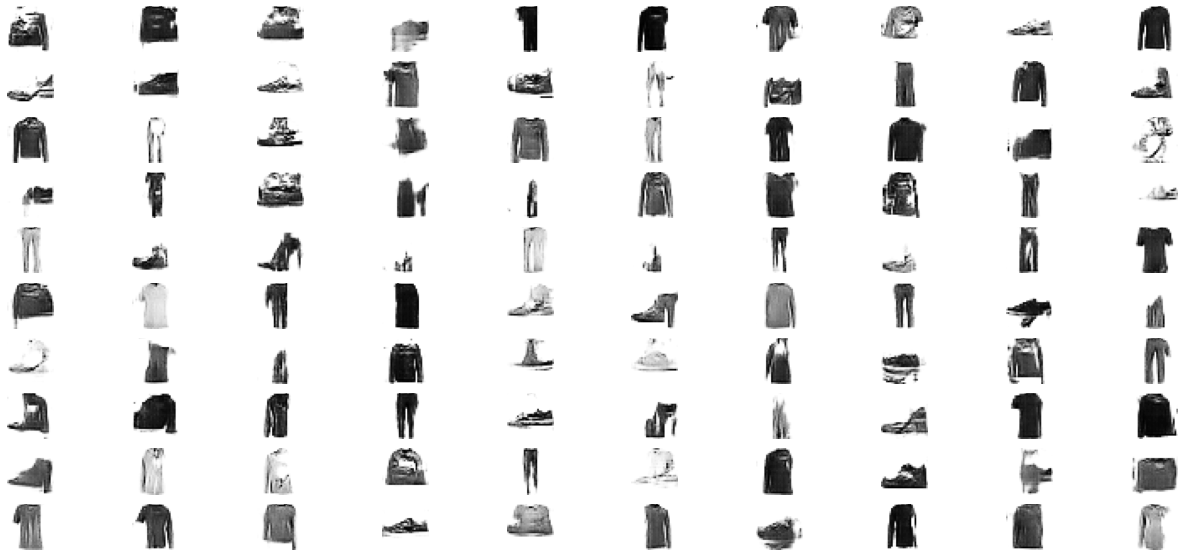

In [ ]:
latent_points = generate_latent_points(100, 100)
X = generator.predict(latent_points)
X = X.reshape(len(X), 28, 28)

plt.figure(figsize=(22,10))
for i in range(100):
  plt.subplot(10, 10, 1 + i)
  plt.axis('off')
  plt.imshow(X[i], cmap='gray_r')
plt.show()

<br>

Some generated contents are not that bad.

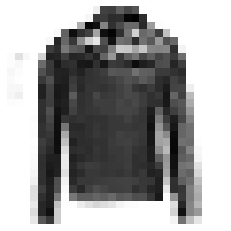

In [ ]:
plt.axis('off')
plt.imshow(X[20], cmap='gray_r')

<br>

Others are very bad. We could make our Discriminator and Generator CNNs more complex, or increase the number of epochs during the training process! This would improve the final results.

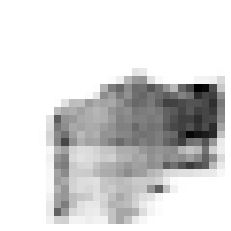

In [ ]:
plt.axis('off')
plt.imshow(X[3], cmap='gray_r')

<br><hr>

## Conditional GAN

Also this part of the lab is based on the same Keras tutorial: [How to Develop a Conditional Generative Adversarial Network from Scratch](https://machinelearningmastery.com/how-to-develop-a-conditional-generative-adversarial-network-from-scratch/)

<br>

To build the simple GAN we used the Keras Sequential API. Here, we need to feed the GAN with multiple inputs. To do that, we can use the Keras Functional API.

First of all, let's build the Discriminator. The first input is one of the image of the dataset. The second input is the integer related to the label of the image.

The label is given to a 50 sized Embedding layer. In this way, each of the 10 classes of the dataset is mapped to a different 50-dimensional vector learnt by the Discriminator. The output of the Embedding layer is given to a Fully Connected (Dense) layer with a number of neurons equals to 28x28. In this way, the output of this layer can be then reshaped in order to obtain the same shape of an input image (i.e., 28x28x1).

Hence, we can concatenate the two inputs. The rest of the model is the same as the Discriminator built for the simple GAN.

In [ ]:
from keras.optimizers import Adam
from keras.models import Model
from keras.layers import Input, Dense, Reshape, Flatten, Conv2D, Conv2DTranspose, LeakyReLU, Dropout, Embedding, Concatenate

def get_discriminator(input_shape=(28,28,1), n_classes=10):
  input_image = Input(shape=input_shape) # first input: an image

  input_label = Input(shape=(1,))     # second input: a label
  lab_input = Embedding(n_classes, 50)(input_label)
  n_neurons = input_shape[0] * input_shape[1]
  lab_input = Dense(n_neurons)(lab_input)   # scale up to image dimensions
  lab_input = Reshape((input_shape[0], input_shape[1], 1))(lab_input) # reshape to add the one-dimensional color channel

  merge = Concatenate()([input_image, lab_input]) # concat the two inputs

  x = Conv2D(128, (3,3), strides=(2,2), padding='same')(merge)  # downsample
  x = LeakyReLU(alpha=0.2)(x)
  x = Conv2D(128, (3,3), strides=(2,2), padding='same')(x)  # downsample
  x = LeakyReLU(alpha=0.2)(x)
  x = Flatten()(x)  # flatten to obtain a vector
  x = Dropout(0.4)(x)
  output_layer = Dense(1, activation='sigmoid')(x)

  model = Model([input_image, input_label], output_layer)
  opt = Adam(lr=0.0002, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
  return model

<br>

Also the Generator receives multi inputs. The first input is a point taken from the latent space. It is then reshaped to obtain 128 feature maps of shape 7x7.
The second input is the class label. Also this input is then reshaped to obtain a single 7x7 feature map.

Since both the inputs have been reshaped to a 7x7 shape, we can concatenate them. The rest of the model is the same as the Generator built for the simple GAN.

In [ ]:
def get_generator(latent_dim, n_classes=10):
  input_latent_repr = Input(shape=(latent_dim,))  # first input: a latent representation
  n_nodes = 128 * 7 * 7
  latent_input = Dense(n_nodes)(input_latent_repr)
  latent_input = LeakyReLU(alpha=0.2)(latent_input)
  latent_input = Reshape((7, 7, 128))(latent_input)   # 128 feature maps of shape 7x7

  input_label = Input(shape=(1,))   # second input: a label
  label_input = Embedding(n_classes, 50)(input_label)
  n_neurons = 7 * 7
  label_input = Dense(n_neurons)(label_input)
  label_input = Reshape((7, 7, 1))(label_input)   # add one-dimensional color channel

  merge = Concatenate()([latent_input, label_input])  # concat the two inputs

  x = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(merge)   # upsample to 128 feature maps of shape 14x14
  x = LeakyReLU(alpha=0.2)(x)
  x = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(x)       # upsample to 128 feature maps of shape 28x28
  x = LeakyReLU(alpha=0.2)(x)
  output_layer = Conv2D(1, (7,7), activation='tanh', padding='same')(x)

  model = Model([input_latent_repr, input_label], output_layer)
  return model

<br>

The GAN takes as input a point from the latent space and a class label. Its Discriminator will predict whether the input is real or fake.

In [ ]:
def get_gan(generator, discriminator):
  discriminator.trainable = False             # make the Discriminator weights not trainable
  gen_latent_repr, gen_label = generator.input      # get latent representation and label inputs from the Generator
  gen_output = generator.output               # get image output from the Generator
  gan_output = discriminator([gen_output, gen_label])   # Generator output and label will be the input of the Discriminator
  model = Model([gen_latent_repr, gen_label], gan_output)   # the input of the GAN is the same of the Generator, the output will be the Discriminator output

  opt = Adam(lr=0.0002, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer=opt)
  return model

<br>

The function get_real_samples() now returns a batch of images taken from the training set with the corresponding labels. At the same time, it returns the class labels for the Discriminator (class = 1, that indicates real examples for the Discriminator).

In [ ]:
import numpy as np

def get_real_samples(trainX, trainy, n_samples):
  X = np.expand_dims(trainX, axis=-1)   # add one-dimensional color dimension
  X = X.astype('float32')   # from integers to floats
  X = (X - 127.5) / 127.5   # scaling from [0,255] to [-1,1]

  idxs = randint(0, len(X), n_samples)    # choose random instances
  X, trainy = X[idxs], trainy[idxs]
  y = np.ones((n_samples, 1))     # generate class labels. Class = 1 (ones function) indicates real samples
  return [X, trainy], y

<br>

The generate_latent_points() function generates points randomly generated from the latent space, but also randomly generated integers representing the class labels of these points.

In [ ]:
from numpy.random import randn
from numpy.random import randint

def generate_latent_points(latent_dim, n_samples, n_classes=10):
	x_input = randn(latent_dim * n_samples)       # generate random points in the latent space
	z_input = x_input.reshape(n_samples, latent_dim)    # reshape into batches that will be the input of the network
	labels = randint(0, n_classes, n_samples)     # generate labels
	return [z_input, labels]

<br>

The generate_fake_samples() function returns the images generated by the Generator with their generated labels, but also the class labels for the Discriminator (class = 0, that indicates fake examples for the Discriminator). Remember that we separately train the Discriminator with the real and fake class labels, but then during the training of the Generator we fool the discriminator labelling also the fake data with the real class label (class = 1).

In [ ]:
def generate_fake_samples(generator, latent_dim, n_samples):
	z_input, labels_input = generate_latent_points(latent_dim, n_samples)
	X = generator.predict([z_input, labels_input])   # generate new content
	y = np.zeros((n_samples, 1))      # generate class labels. Class = 0 (zeros function) indicates fake samples 
	return [X, labels_input], y

<br>

The train() function must use the class labels to train the Discriminator and the Generator.

In [ ]:
def train(generator, discriminator, gan, training_set, latent_dim, n_epochs=25, n_batch=256):
  batch_per_epoch = int(len(training_set[0]) / n_batch)
  half_batch = int(n_batch / 2)

  for i in range(n_epochs):     # one iteration per epoch
    for j in range(batch_per_epoch):    # one iteration per batch
      [X_real, labels_real], y_real = get_real_samples(training_set[0], training_set[1], half_batch)     # randomly pick real examples

      discriminator_loss1, _ = discriminator.train_on_batch([X_real, labels_real], y_real)      # update the Discriminator weights based on real examples

      [X_fake, labels], y_fake = generate_fake_samples(generator, latent_dim, half_batch)       # generate fake examples

      discriminator_loss2, _ = discriminator.train_on_batch([X_fake, labels], y_fake)       # update the Discriminator weights based on fake examples

      [z_input, labels_input] = generate_latent_points(latent_dim, n_batch)     # randomly generate points from the latent space

      y_gan = np.ones((n_batch, 1))     # create labels for the fake examples to fool the Discriminator (so Class = 1 as real examples)

      gan_loss = gan.train_on_batch([z_input, labels_input], y_gan)     # update the Generator weights through the Discriminator's error
      
      # print loss info for each batch of each epoch
      print("\r", end="")
      print("Epoch {}/{} - Batch {}/{} - discr_loss1 = {:.3f} - discr_loss2 = {:.3f} - gan_loss = {:.3f}"
              .format(i+1, n_epochs, j+1, batch_per_epoch, discriminator_loss1, discriminator_loss2, gan_loss), 
              end="", flush=True)
    print()

  generator.save('{}/conditional-generator.h5'.format(project_path))
  return generator

<br>

Let's train the Conditional GAN!

In [ ]:
from keras.datasets.fashion_mnist import load_data
(trainX, trainy), (_, _) = load_data()

latent_dim = 100
discriminator = get_discriminator()
generator = get_generator(latent_dim)
gan_model = get_gan(generator, discriminator)
train(generator, discriminator, gan_model, [trainX, trainy], latent_dim)

Epoch 1/25 - Batch 234/234 - discr_loss1 = 0.765 - discr_loss2 = 0.693 - gan_loss = 0.789
Epoch 2/25 - Batch 234/234 - discr_loss1 = 0.700 - discr_loss2 = 0.698 - gan_loss = 0.730
Epoch 3/25 - Batch 234/234 - discr_loss1 = 0.599 - discr_loss2 = 0.629 - gan_loss = 0.816
Epoch 4/25 - Batch 234/234 - discr_loss1 = 0.699 - discr_loss2 = 0.678 - gan_loss = 0.760
Epoch 5/25 - Batch 234/234 - discr_loss1 = 0.647 - discr_loss2 = 0.654 - gan_loss = 0.796
Epoch 6/25 - Batch 234/234 - discr_loss1 = 0.650 - discr_loss2 = 0.633 - gan_loss = 0.821
Epoch 7/25 - Batch 234/234 - discr_loss1 = 0.632 - discr_loss2 = 0.699 - gan_loss = 0.754
Epoch 8/25 - Batch 234/234 - discr_loss1 = 0.661 - discr_loss2 = 0.650 - gan_loss = 0.779
Epoch 9/25 - Batch 234/234 - discr_loss1 = 0.651 - discr_loss2 = 0.640 - gan_loss = 0.800
Epoch 10/25 - Batch 234/234 - discr_loss1 = 0.701 - discr_loss2 = 0.651 - gan_loss = 0.785
Epoch 11/25 - Batch 234/234 - discr_loss1 = 0.641 - discr_loss2 = 0.670 - gan_loss = 0.767
Epoch 12

<br>

Here, we generate 10 examples for each class of the dataset. Each column represents a different class of the dataset. From left to right we have:

<table>
  <tr>
    <td>t-shirt</td>
    <td>trouser</td>
    <td>pullover</td>
    <td>dress</td>
    <td>coat</td>
    <td>sandal</td>
    <td>shirt</td>
    <td>sneaker</td>
    <td>bag</td>
    <td>ankle boot</td>
  </tr>
</table>

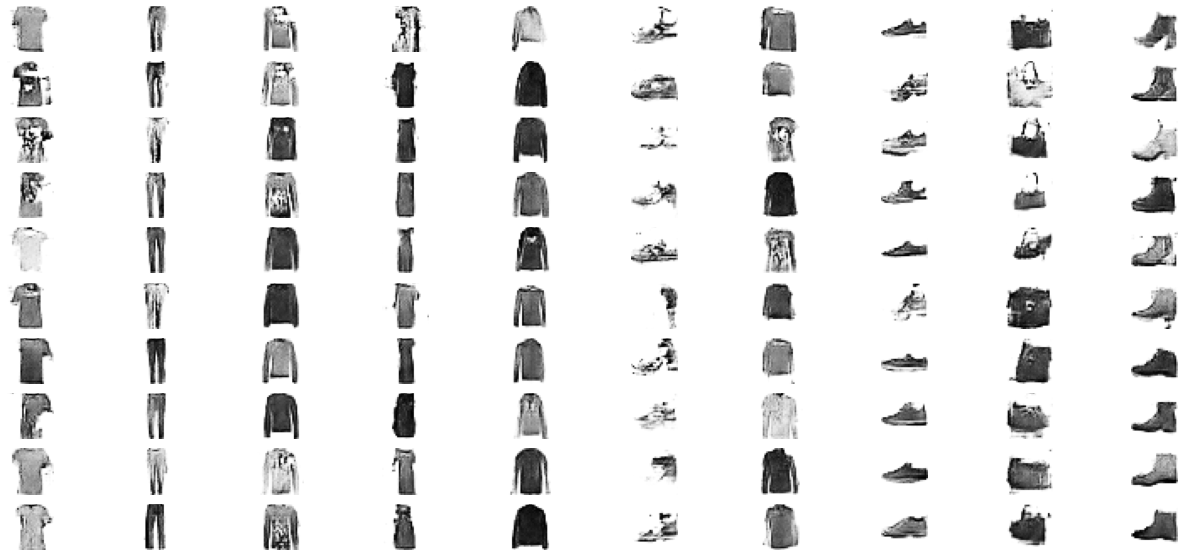

In [ ]:
from keras.models import load_model
generator = load_model('{}/conditional-generator.h5'.format(project_path))

latent_points, labels = generate_latent_points(100, 100)

labels = np.asarray([x for _ in range(10) for x in range(10)])   # specify labels, we will have ten different labels, and each label is repeated 10 times

X = generator.predict([latent_points, labels])
X = (X + 1) / 2.0   # scale from [-1,1] to [0,1]
X = X.reshape(len(X), 28, 28)

plt.figure(figsize=(22,10))
for i in range(100):
  plt.subplot(10, 10, 1 + i)
  plt.axis('off')
  plt.imshow(X[i], cmap='gray_r')
plt.show()

<br><hr>

## Cycle GAN
This part of the lab is based on the following tutorials: [CycleGAN](https://keras.io/examples/generative/cyclegan/) and [How to Develop a CycleGAN for Image-to-Image Translation with Keras](https://machinelearningmastery.com/cyclegan-tutorial-with-keras/)

We are going to build a CycleGAN which can transform pictures of horses to zebras, and viceversa.

<br>

First of all, we have to load the dataset containing 256x256 images of horses and zebras. We will use the library *tensorflow_datasets*.

In [ ]:
import tensorflow_datasets as tfds
import numpy as np

dataset, info = tfds.load("cycle_gan/horse2zebra", with_info=True, as_supervised=True)
train_horses, train_zebras = dataset["trainA"], dataset["trainB"]
test_horses, test_zebras = dataset["testA"], dataset["testB"]

Shuffling and writing examples to /root/tensorflow_datasets/cycle_gan/horse2zebra/2.0.0.incompleteJ0I21T/cycle_gan-trainA.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/cycle_gan/horse2zebra/2.0.0.incompleteJ0I21T/cycle_gan-trainB.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/cycle_gan/horse2zebra/2.0.0.incompleteJ0I21T/cycle_gan-testA.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/cycle_gan/horse2zebra/2.0.0.incompleteJ0I21T/cycle_gan-testB.tfrecord


Dataset cycle_gan downloaded and prepared to /root/tensorflow_datasets/cycle_gan/horse2zebra/2.0.0. Subsequent calls will reuse this data.


<br>

Here, we
*   split the dataset in images and labels, both for horses and zebras
*   concatenate training and test sets (related to horses and zebras), removing the test sets
*   print the shape of the training sets related to horses and zebras

In [ ]:
train_horses_X, train_horses_y = np.array(tuple(zip(*train_horses)), dtype=np.ndarray)
train_zebras_X, train_zebras_y = np.array(tuple(zip(*train_zebras)), dtype=np.ndarray)
test_horses_X, test_horses_y = np.array(tuple(zip(*test_horses)), dtype=np.ndarray)
test_zebras_X, test_zebras_y = np.array(tuple(zip(*test_zebras)), dtype=np.ndarray)

horses_X = np.concatenate((train_horses_X, test_horses_X))
horses_y = np.concatenate((train_horses_y, test_horses_y))
zebras_X = np.concatenate((train_zebras_X, test_zebras_X))
zebras_y = np.concatenate((train_zebras_y, test_zebras_y))

horses_X = np.asarray(list(horses_X))
zebras_X = np.asarray(list(zebras_X))
print(horses_X.shape)
print(zebras_X.shape)

(1187, 256, 256, 3)
(1474, 256, 256, 3)


<br>

Let's plot some examples taken from the training sets.

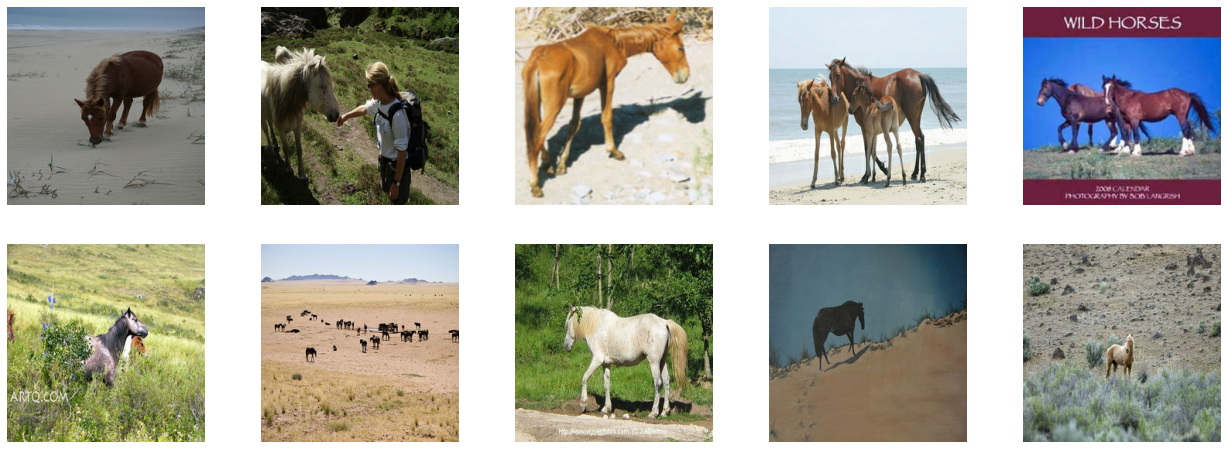

In [ ]:
from matplotlib import pyplot as plt

plt.figure(figsize=(22, 8))
for i in range(10):
  plt.subplot(2, 5, i+1)
  plt.axis('off')
  plt.imshow(horses_X[i])
plt.show()

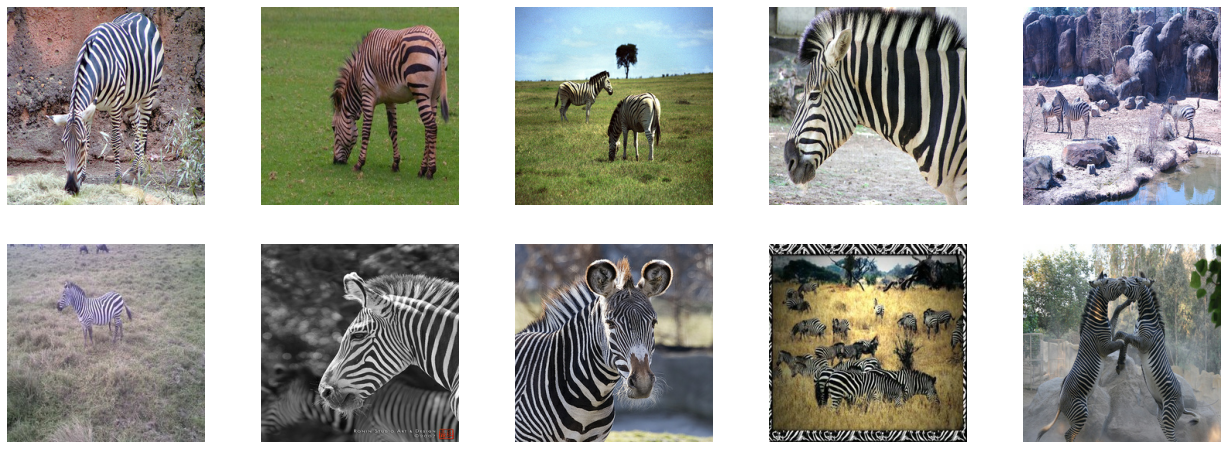

In [ ]:
plt.figure(figsize=(22, 8))
for i in range(10):
  plt.subplot(2, 5, i+1)
  plt.axis('off')
  plt.imshow(zebras_X[i])
plt.show()

<br>

Scaling data from [0, 255] to [-1, 1]. This interval of values is a typical format for GANs.

In [ ]:
horses_X = (horses_X - 127.5) / 127.5
zebras_X = (zebras_X - 127.5) / 127.5
dataset = horses_X, zebras_X

print(horses_X.shape)
print(zebras_X.shape)

del train_horses_X
del train_horses_y
del train_zebras_X 
del train_zebras_y
del test_horses_X
del test_horses_y
del test_zebras_X
del test_zebras_y

(1187, 256, 256, 3)
(1474, 256, 256, 3)


<br>

Within the Discriminators of the CycleGAN we want to use the InstanceNormalization layer, instead of the BatchNormalization one. With InstanceNormalization we scale to a standard Gaussian distribution the values of each feature map. With BatchNormalization, instead, the values are standardize considering the features of the whole training batch.

The Keras library does not provide the InstanceNormalization layer. Here, we use the [Keras-contrib](https://github.com/keras-team/keras-contrib) library, the official extension repository for the Keras library.

In [ ]:
!git clone https://www.github.com/keras-team/keras-contrib.git

%cd keras-contrib

!python setup.py install

Cloning into 'keras-contrib'...
remote: Enumerating objects: 3634, done.
remote: Total 3634 (delta 0), reused 0 (delta 0), pack-reused 3634
Receiving objects: 100% (3634/3634), 861.24 KiB | 14.85 MiB/s, done.
Resolving deltas: 100% (2330/2330), done.
/content/keras-contrib
running install
running bdist_egg
running egg_info
creating keras_contrib.egg-info
writing keras_contrib.egg-info/PKG-INFO
writing dependency_links to keras_contrib.egg-info/dependency_links.txt
writing requirements to keras_contrib.egg-info/requires.txt
writing top-level names to keras_contrib.egg-info/top_level.txt
writing manifest file 'keras_contrib.egg-info/SOURCES.txt'
writing manifest file 'keras_contrib.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build
creating build/lib
creating build/lib/keras_contrib
copying keras_contrib/__init__.py -> build/lib/keras_contrib
creating build/lib/keras_contrib/applications
copying keras_contrib/

<br>

Here, we define the function used to build each Discriminator of the CycleGAN. You can find some implementation details directly in the [Unpaired Image-to-Image Translation using Cycle-Consistent Adversarial Networks](https://arxiv.org/pdf/1703.10593.pdf) paper, on which are based the tutorials we are considering. 

In the mentioned paper, the Discriminator is called PatchGAN Discriminator since it detects whether overlapping image patches are real or fake. In this way, the Discriminator has a lower number of parameters than a full-image solution. The weights loss are halved to slow down the Discriminator updates.

In [ ]:
from keras.initializers import RandomNormal
from keras.optimizers import Adam
from keras.models import Model, Input
from keras.layers import Conv2D, Conv2DTranspose, LeakyReLU, Activation, Concatenate
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization

def get_discriminator(image_shape):
	kernel_init = RandomNormal(mean=0.0, stddev=0.02)     # weight initialization
	input_image = Input(shape=image_shape)

	d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=kernel_init)(input_image)
	d = LeakyReLU(alpha=0.2)(d)

	d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=kernel_init)(d)
	d = InstanceNormalization(axis=-1)(d)
	d = LeakyReLU(alpha=0.2)(d)

	d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=kernel_init)(d)
	d = InstanceNormalization(axis=-1)(d)
	d = LeakyReLU(alpha=0.2)(d)

	d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=kernel_init)(d)
	d = InstanceNormalization(axis=-1)(d)
	d = LeakyReLU(alpha=0.2)(d)

	d = Conv2D(512, (4,4), padding='same', kernel_initializer=kernel_init)(d)
	d = InstanceNormalization(axis=-1)(d)
	d = LeakyReLU(alpha=0.2)(d)
	output = Conv2D(1, (4,4), padding='same', kernel_initializer=kernel_init)(d)
 
	model = Model(input_image, output)
	model.compile(loss='mse', optimizer=Adam(lr=0.0002, beta_1=0.5), loss_weights=[0.5])
	return model

<br>

In the Generator, we will use a stack of Residual blocks. 
Each Residual block concatenates its input with its output. As explained in [Understanding and Implementation of Residual Networks (ResNets)](https://medium.com/analytics-vidhya/understanding-and-implementation-of-residual-networks-resnets-b80f9a507b9c) and in [Residual Block Explained](https://paperswithcode.com/method/residual-block), Residual blocks can be used to build deep neural networks with a very high number of hidden layers without a worsening of the performance because of the vanishing gradient problem.

<img src='https://miro.medium.com/max/848/1*N5FPYoOt6OhC-xTGO5chFQ.png'>

The layers of a neural network learn a mapping function M between their input x and their output:

<center><em>y: M(x) = y</em></center>

Instead, Residual blocks learn the difference between a mapping function applied to X and the original input X: 

<center><em>F(x) = M(x) - x</em></center>
<center><em>M(x) = F(x) + x</em></center>

The original mapping *M(x)* is converted into *F(x) + x*, where *x* acts like a residual. This is the reason behind the name Residual block. The idea is that it's easier to optimize the mapping *M(x) = F(x) + x* than the original mapping *M(x) = y*.

In [ ]:
def get_resnet_block(n_filters, input_layer):
	kernel_init = RandomNormal(mean=0.0, stddev=0.02)     # weight initialization

	block = Conv2D(n_filters, (3,3), padding='same', kernel_initializer=kernel_init)(input_layer)
	block = InstanceNormalization(axis=-1)(block)
	block = Activation('relu')(block)
 
	block = Conv2D(n_filters, (3,3), padding='same', kernel_initializer=kernel_init)(block)
	block = InstanceNormalization(axis=-1)(block)
	
	block = Concatenate()([block, input_layer])   # concatenate the output of the block with its input
	return block

<br>


The Generator starts with three Convolutional layers to downsample the input images. Then, the feature maps are given to a stack of Residual blocks. 
Finally, data are upsampled thanks to other Convolutional layers, and then a final layer will generate a single RGB feature map.

In [ ]:
def get_generator(image_shape, n_resnet=9):
	kernel_init = RandomNormal(mean=0.0, stddev=0.02)     # weight initialization
	in_image = Input(shape=image_shape)

	g = Conv2D(64, (7,7), padding='same', kernel_initializer=kernel_init)(in_image)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)

	g = Conv2D(128, (3,3), strides=(2,2), padding='same', kernel_initializer=kernel_init)(g)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)

	g = Conv2D(256, (3,3), strides=(2,2), padding='same', kernel_initializer=kernel_init)(g)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)

	for _ in range(n_resnet):
		g = get_resnet_block(256, g)

	g = Conv2DTranspose(128, (3,3), strides=(2,2), padding='same', kernel_initializer=kernel_init)(g)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)

	g = Conv2DTranspose(64, (3,3), strides=(2,2), padding='same', kernel_initializer=kernel_init)(g)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)

	g = Conv2D(3, (7,7), padding='same', kernel_initializer=kernel_init)(g)
	g = InstanceNormalization(axis=-1)(g)
	out_image = Activation('tanh')(g)

	model = Model(in_image, out_image)
	return model

<br>

As the previous GANs, the Discriminators are trained at first directly on the real and fake images. So we make only one Generator trainable in the Cycle GAN.

Each Generator will be trained
*   to maximize its Discriminator loss (Adversarial Loss)
*   to minimize the difference between the input image taken from the source domain and output image generated by the other Generator once received the image generated by the Generator itself (Forward Cycle Loss)
*   to minimize the difference between the input image generated by the other Generator and the output image generated by the Generator itself (Backward Cycle Loss)
*   to minimize the difference between an input image from the target domain and its reconstruction without translation (Identity Loss)

Note that, considering a Generator that has to learn how to translate horses images to zebras images, the source domain will contain horses images, while the target domain will contain zebras images.

Each Generator will be updated considering the weighted sum of these loss functions. The most important loss is the Cycle Loss (the weight is 10-times greater than the Adversarial Loss one), as described in the [Unpaired Image-to-Image Translation using Cycle-Consistent Adversarial Networks](https://arxiv.org/pdf/1703.10593.pdf) paper.

In [ ]:
def get_cycle_gan(generator_1, discriminator, generator_2, image_shape):
	generator_1.trainable = True                # only the first Generator will be trained
	discriminator.trainable = False             
	generator_2.trainable = False               

  # Adversarial component
	generator_input = Input(shape=image_shape)
	generator1_output = generator_1(generator_input)
	discriminator_output = discriminator(generator1_output)
	
  # Identity component
	input_identity = Input(shape=image_shape)
	output_identity = generator_1(input_identity)
	
  # Forward cycle component
	output_forward = generator_2(generator1_output)
	
  # Backward cycle component
	generator2_output = generator_2(input_identity)
	output_backward = generator_1(generator2_output)
 
	model = Model([generator_input, input_identity], [discriminator_output, output_identity, output_forward, output_backward])
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss=['mse', 'mae', 'mae', 'mae'], loss_weights=[1, 5, 10, 10], optimizer=opt)
	return model

<br>

As always, we define two functions to randomly pick a batch of real sample from the dataset and to generate fake samples with a Generator, respectively. Note that, *patch_shape* is based on the output shape of the Discriminator related to the Generator we are using to generate fake samples.

In [ ]:
from numpy.random import randint

# Randomly pick a batch of samples
def generate_real_samples(training_set, n_samples, patch_shape):
  idxs = randint(0, training_set.shape[0], n_samples)
  X = training_set[idxs] 
  y = np.ones((n_samples, patch_shape, patch_shape, 1))   # generate class = 1 for 'real' examples
  return X, y



# Generate images with the Generator 
def generate_fake_samples(generator, real_samples, patch_shape):
  X = generator.predict(real_samples)
  y = np.zeros((len(X), patch_shape, patch_shape, 1))    # generate class = 0 for 'fake' examples
  return X, y

<br>

As explain in the [Unpaired Image-to-Image Translation using Cycle-Consistent Adversarial Networks](https://arxiv.org/pdf/1703.10593.pdf) paper, each Discriminator is updated using a history of 50 previously generated images. When the history list if full, the newly generated image can replace the ones of the history.

In [ ]:
from random import random

def update_fake_images_history(history, images, max_size=50):
  selected = list()
  for image in images:
    if len(history) < max_size:      # fill the history
      history.append(image)
      selected.append(image)    
    elif random() < 0.5:          # use image, but don't add it to the history
      selected.append(image)
    else:                         # replace an existing image of the history with a newly generated image
      idx = randint(0, len(history))
      selected.append(history[idx])
      history[idx] = image
  return np.asarray(selected)

<br>

Utility functions:
*   save_models: to save the two Generators after a specific epoch of the training process
*   save_comparison_images: save an image in which are compared some images taken from the source domain of a Generator to the translated images obtained thanks to the same Generator

In [ ]:
def save_models(epoch, generator_H2Z, generator_Z2H):
  filename1 = '{}/gen_H2Z_at_epoch_{}.h5'.format(project_path, epoch)
  generator_H2Z.save(filename1)

  filename2 = '{}/gen_Z2H_at_epoch_{}.h5'.format(project_path, epoch)
  generator_Z2H.save(filename2)
  print('\tGenerators saved!')




def save_comparison_images(epoch, generator, trainX, name, n_samples=5):
  X_input, _ = generate_real_samples(trainX, n_samples, 0)
  X_output, _ = generate_fake_samples(generator, X_input, 0)

  # scale all pixels from [-1,1] to [0,255]
  X_input = ((X_input - X_input.min()) * (1/(X_input.max() - X_input.min()) * 255)).astype('uint8')
  X_output = ((X_output - X_output.min()) * (1/(X_output.max() - X_output.min()) * 255)).astype('uint8')

  # plot real images
  for i in range(n_samples):
    plt.subplot(2, n_samples, 1 + i)
    plt.axis('off')
    plt.imshow(X_input[i])

  # plot translated images
  for i in range(n_samples):
    plt.subplot(2, n_samples, 1 + n_samples + i)
    plt.axis('off')
    plt.imshow(X_output[i])

  filename = '{}/{}_generated_at_epoch_{}.png'.format(project_path, name, epoch)
  plt.savefig(filename)
  plt.close()

<br>

This is the training process implementation. We select a batch of real samples from each domain and then we generate the corresponding fake samples for the opposite domains. Hence, we update the fake samples history for each Discriminator.

So, we update the Zebras-to-Horses Generator, the Horses Discriminator, the Horses-to-Zebras Generator, and the Zebras Discriminator.

Every 2 epochs, we save the Generators and the comparisons between a batch of source images and the corresponding translated images.
Note that, at each step, for each Generator we print only one of the loss considered by the *get_cycle_gan* function.

In [ ]:
def train(discriminator_horses, discriminator_zebras, generator_H2Z, generator_Z2H, cycle_gan_H2Z, cycle_gan_Z2H, dataset):
  n_epochs, n_batch, = 50, 1     
  n_patch = discriminator_horses.output_shape[1]     # the output shape of the discriminator
  trainH, trainZ = dataset                      # split the dataset in horses and zebras images
  histH, histZ = list(), list()                 # prepare pools for fake images
  batch_per_epochs = int(len(trainH) / n_batch)

  n_steps = batch_per_epochs * n_epochs         # get the number of training iterations
  for i in range(n_steps):                      # for each training iteration
    realH_X, realH_y = generate_real_samples(trainH, n_batch, n_patch)      # pick a batch of 'real' samples from the dataset
    realZ_X, realZ_y = generate_real_samples(trainZ, n_batch, n_patch)

    fakeH_X, fakeH_y = generate_fake_samples(generator_Z2H, realZ_X, n_patch) # generate a batch of 'fake' samples with the Generator
    fakeZ_X, fakeZ_y = generate_fake_samples(generator_H2Z, realH_X, n_patch)

    fakeH_X = update_fake_images_history(histH, fakeH_X)     # update the pools of 'fake' images
    fakeZ_X = update_fake_images_history(histZ, fakeZ_X)

    # update Generator Zebra to Horse
    generator_loss2, _, _, _, _  = cycle_gan_Z2H.train_on_batch([realZ_X, realH_X], [realH_y, realH_X, realZ_X, realH_X])

    # update Discriminator for Horses
    discriminator_horses_loss1 = discriminator_horses.train_on_batch(realH_X, realH_y)
    discriminator_horses_loss2 = discriminator_horses.train_on_batch(fakeH_X, fakeH_y)

    # update Generator Horse to Zebra
    generator_loss1, _, _, _, _ = cycle_gan_H2Z.train_on_batch([realH_X, realZ_X], [realZ_y, realZ_X, realH_X, realZ_X])

    # update Discriminator for Zebras
    discriminator_zebras_loss1 = discriminator_zebras.train_on_batch(realZ_X, realZ_y)
    discriminator_zebras_loss2 = discriminator_zebras.train_on_batch(fakeZ_X, fakeZ_y)

    # print loss info for each batch of each epoch
    print("\r", end="")
    print("Step {}/{} - discr_horses = [{:.3f}, {:.3f}] - discr_zebras = [{:.3f}, {:.3f}] - generators_loss = [{:.3f}, {:.3f}]"
            .format(i+1, n_steps, discriminator_horses_loss1, discriminator_horses_loss2, discriminator_zebras_loss1, discriminator_zebras_loss2, generator_loss1, generator_loss2), 
            end="", flush=True)

    if (i+1) % batch_per_epochs == 0:   # end of one epoch   
      print()
    if (i+1) in [batch_per_epochs*j for j in range(2, 51, 2)]:  # after epochs 2, 4, ..., and 50
      epoch = (i+1)/batch_per_epochs
      save_comparison_images(epoch, generator_H2Z, trainH, 'H2Z')
      save_comparison_images(epoch, generator_Z2H, trainZ, 'Z2H')
      save_models(epoch, generator_H2Z, generator_Z2H)
  print()
  return generator_H2Z, generator_Z2H

<br>

Here, we create the two Generators, the two Discriminators, and we combine them in the two cycle GANs.

In [ ]:
image_shape = horses_X[0].shape

print("Getting generators...")
generator_H2Z = get_generator(image_shape)
generator_Z2H = get_generator(image_shape)

print("Getting discriminators...")
discriminator_horses = get_discriminator(image_shape)
discriminator_zebras = get_discriminator(image_shape)

print("Getting cycle GANs...")
cycle_gan_H2Z = get_cycle_gan(generator_H2Z, discriminator_zebras, generator_Z2H, image_shape)
cycle_gan_Z2H = get_cycle_gan(generator_Z2H, discriminator_horses, generator_H2Z, image_shape)

print("Start training!")
generator_H2Z, generator_Z2H = train(discriminator_horses, discriminator_zebras, generator_H2Z, generator_Z2H, cycle_gan_H2Z, cycle_gan_Z2H, dataset)

Getting generators...
Getting discriminators...
Getting cycle GANs...
Start training!
Step 1187/59350 - discr_horses = [0.162, 0.068] - discr_zebras = [0.177, 0.150] - generators_loss = [4.101, 4.774]
Step 2374/59350 - discr_horses = [0.199, 0.080] - discr_zebras = [0.034, 0.011] - generators_loss = [5.033, 4.819]
	Generators saved!
Step 3561/59350 - discr_horses = [0.038, 0.021] - discr_zebras = [0.038, 0.022] - generators_loss = [5.743, 6.842]
Step 4748/59350 - discr_horses = [0.018, 0.008] - discr_zebras = [0.037, 0.028] - generators_loss = [8.070, 9.682]
	Generators saved!
Step 5935/59350 - discr_horses = [0.007, 0.029] - discr_zebras = [0.083, 0.011] - generators_loss = [5.166, 5.171]
Step 7122/59350 - discr_horses = [0.015, 0.018] - discr_zebras = [0.064, 0.131] - generators_loss = [3.736, 4.033]
	Generators saved!
Step 8309/59350 - discr_horses = [0.005, 0.159] - discr_zebras = [0.240, 0.275] - generators_loss = [4.534, 5.549]
Step 9496/59350 - discr_horses = [0.004, 0.036] - di

<br>

The training is a very long process. I just train the Cycle GAN for 8 epochs. These are the preliminary results. To obtain something that works good, we should train the Cycle GAN for more epochs!

In [ ]:
from keras.models import load_model

def plot_comparison(original_img, translated_img, reconstructed_img):
  original_img = ((original_img - original_img.min()) * (1/(original_img.max() - original_img.min()) * 255)).astype('uint8')
  translated_img = ((translated_img - translated_img.min()) * (1/(translated_img.max() - translated_img.min()) * 255)).astype('uint8')
  reconstructed_img = ((reconstructed_img - reconstructed_img.min()) * (1/(reconstructed_img.max() - reconstructed_img.min()) * 255)).astype('uint8')

  plt.figure(figsize=(22,8))

  plt.subplot(1,3,1)
  plt.axis('off')
  plt.title('Original', fontsize=22)
  original_img = original_img.reshape((256, 256, 3))
  plt.imshow(original_img)
  plt.subplot(1,3,2)
  plt.axis('off')
  plt.title('Translated', fontsize=22)
  translated_img = translated_img.reshape((256, 256, 3))
  plt.imshow(translated_img)
  plt.subplot(1,3,3)
  plt.axis('off')
  plt.title('Reconstructed', fontsize=22)
  reconstructed_img = reconstructed_img.reshape((256, 256, 3))
  plt.imshow(reconstructed_img)
  plt.show()


custom_objs = {'InstanceNormalization': InstanceNormalization}
generator_H2Z = load_model('{}/gen_H2Z_at_epoch_8.0.h5'.format(project_path), custom_objs)
generator_Z2H = load_model('{}/gen_Z2H_at_epoch_8.0.h5'.format(project_path), custom_objs)

<br>

Horse -> Zebra -> Horse <br>
After 8 epochs, the Generator just starts to add some stripes on the horse.

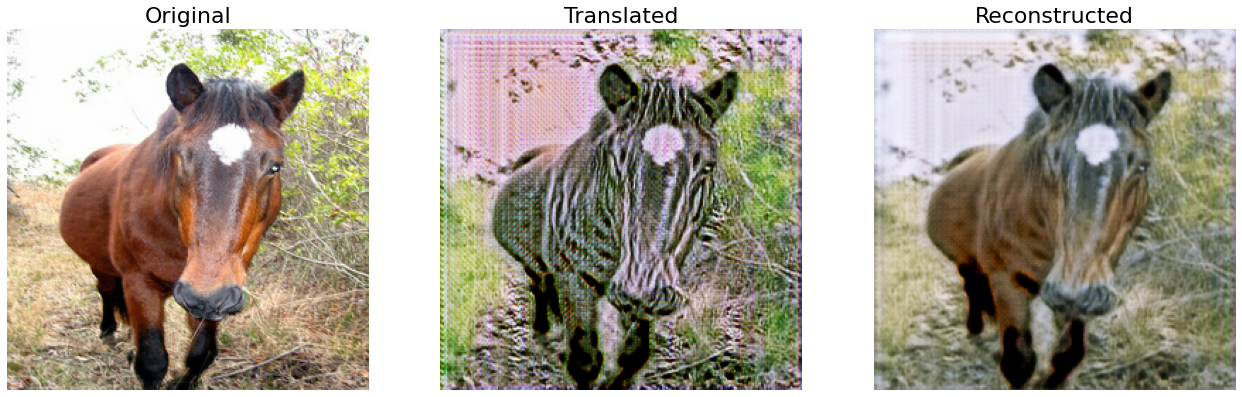

In [ ]:
input_img = horses_X[30].reshape((1, 256, 256, 3))
generated  = generator_H2Z.predict(input_img)
reconstructed = generator_Z2H.predict(generated)
plot_comparison(input_img, generated, reconstructed)

<br>

Zebra -> Horse -> Zebra <br>
After 8 epochs, we can see that the Generator starts to transform part of the zebra to a brown horse.

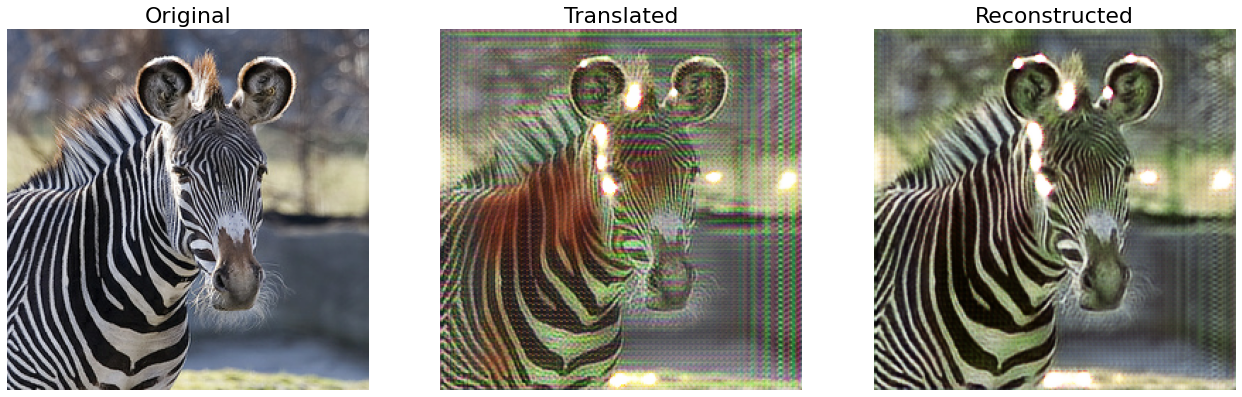

In [ ]:
input_img = zebras_X[7].reshape((1, 256, 256, 3))
generated  = generator_Z2H.predict(input_img)
reconstructed = generator_H2Z.predict(generated)
plot_comparison(input_img, generated, reconstructed)

<br>

In [How to Develop a CycleGAN for Image-to-Image Translation with Keras](https://machinelearningmastery.com/cyclegan-tutorial-with-keras/) you can see a possible result after about 50 epochs!

<center><img src='https://github.com/lucaArrotta/Autoencoders-and-GANs-with-Python/blob/main/imgs/50EpochsCycleGAN.jpg?raw=true'></center>